In [19]:
from itertools import islice

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange

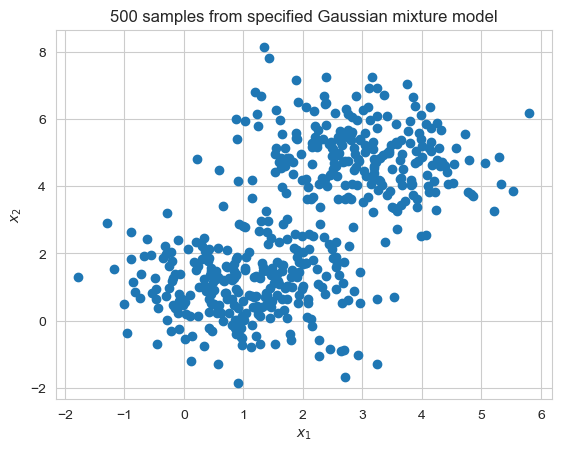

In [2]:
torch.random.manual_seed(42)
mixture = dist.MixtureSameFamily(
    dist.Categorical(torch.tensor([0.5, 0.5], dtype=torch.float32)),
    dist.MultivariateNormal(
        torch.tensor([[1, 1], [3, 5]], dtype=torch.float32),
        torch.stack([torch.eye(2), torch.eye(2)]),
    ),
)

sample = np.asarray(mixture.sample((500,)))
plt.scatter(sample[:, 0], sample[:, 1])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("500 samples from specified Gaussian mixture model")
plt.show()

In [3]:
def condition_first(
    gmm: dist.MixtureSameFamily, cond: torch.Tensor
) -> dist.MixtureSameFamily:
    (c,) = cond.shape
    cat: dist.Categorical = gmm.mixture_distribution
    norm: dist.MultivariateNormal = gmm.component_distribution
    s_11 = norm.covariance_matrix[:, :c, :c]
    s_21 = norm.covariance_matrix[:, c:, :c]
    s_22 = norm.covariance_matrix[:, c:, c:]
    m_1 = norm.mean[:, :c]
    m_2 = norm.mean[:, c:]
    s_21_inv_s11 = s_21 @ torch.linalg.inv(s_11)
    cond_cat = dist.Categorical(
        logits=(
            cat.logits
            + dist.MultivariateNormal(loc=m_1, covariance_matrix=s_11).log_prob(cond)
        )
    )
    cond_norm = dist.MultivariateNormal(
        loc=m_2 + torch.einsum("knc,kc->kn", s_21_inv_s11, cond - m_1),
        covariance_matrix=s_22 - torch.einsum("knc,kNc->knN", s_21_inv_s11, s_21),
    )
    return dist.MixtureSameFamily(cond_cat, cond_norm)

In [4]:
def plot_conditioned(gmm: dist.MixtureSameFamily, cond: torch.Tensor, ax=None):
    gmm_cond = condition_first(gmm, cond)
    samples = np.asarray(gmm_cond.sample((500,)))
    if ax is None:
        _, ax = plt.subplots()
    sns.kdeplot(samples, ax=ax, legend=False)
    ax.set_xlabel("$x_2$")
    ax.set_xlim((-2, 8))
    ax.set_title(
        f"$x_1={cond[0]}$ "
        f"(new mixing components: {[round(x, 2) for x in gmm_cond.mixture_distribution.probs.tolist()]})"
    )

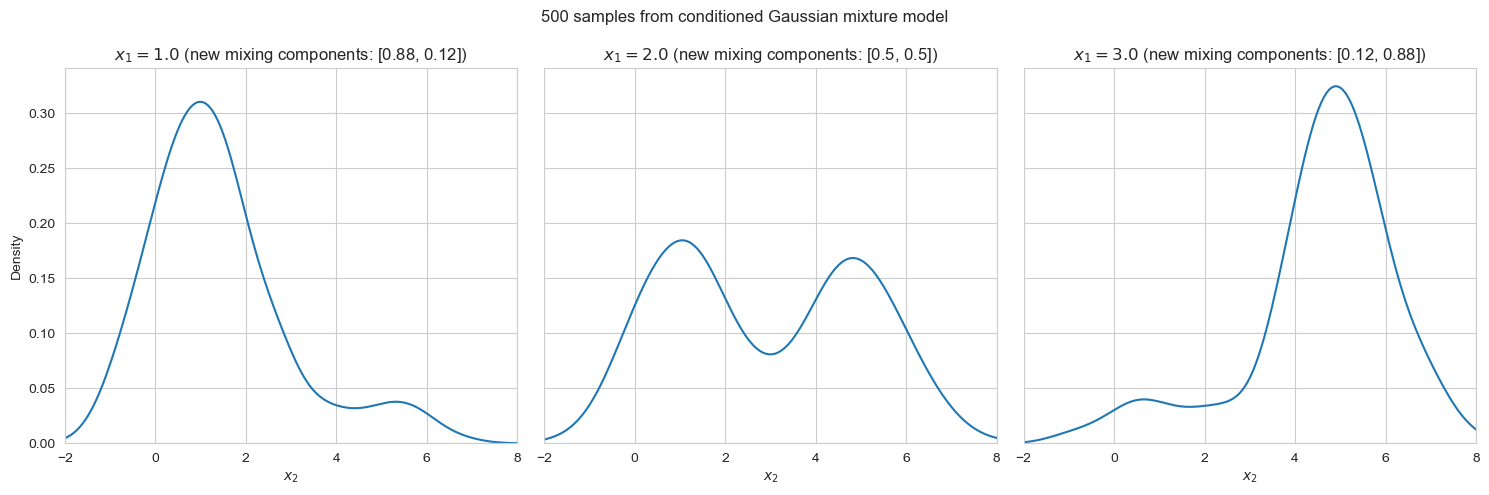

In [5]:
torch.random.manual_seed(42)
_, axs = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
plot_conditioned(mixture, torch.tensor([1], dtype=torch.float32), ax=axs[0])
plot_conditioned(mixture, torch.tensor([2], dtype=torch.float32), ax=axs[1])
plot_conditioned(mixture, torch.tensor([3], dtype=torch.float32), ax=axs[2])
plt.suptitle("500 samples from conditioned Gaussian mixture model")
plt.tight_layout()
plt.show()

In [6]:
train_loader = DataLoader(
    datasets.MNIST(
        "../data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                lambda x: x > 0,
                lambda x: x.float(),
            ]
        ),
    ),
    batch_size=50,
    shuffle=True,
)
test_loader = DataLoader(
    datasets.MNIST(
        "../data",
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                lambda x: x > 0,
                lambda x: x.float(),
            ]
        ),
    ),
    batch_size=50,
    shuffle=True,
)

In [127]:
class VAE(nn.Module):
    def __init__(
        self,
        output_dim: int,
        transform_dims: list[int],
        latent_dim: int,
        multivariate: bool = False,
    ):
        super().__init__()
        self.latent_dim = latent_dim
        trans_enc = []
        for dim in transform_dims:
            trans_enc.append(nn.LazyLinear(dim))
            trans_enc.append(nn.ReLU())
        self.trans_enc = nn.Sequential(*trans_enc)
        self.enc_mean = nn.LazyLinear(latent_dim)
        self.enc_log_var = nn.LazyLinear(
            latent_dim * (latent_dim + 1) // 2 if multivariate else latent_dim
        )
        dec = []
        for dim in reversed(transform_dims):
            dec.append(nn.LazyLinear(dim))
            dec.append(nn.ReLU())
        dec.append(nn.LazyLinear(output_dim))
        dec.append(nn.Sigmoid())
        self.dec = nn.Sequential(*dec)
        self.multivariate = multivariate

    def encode(self, x: torch.Tensor) -> dist.Distribution:
        trans = self.trans_enc(x.view(x.shape[0], -1))
        mean = self.enc_mean(trans)
        var_vals = torch.exp(self.enc_log_var(trans))
        if self.multivariate:
            var = torch.empty((x.shape[0], self.latent_dim, self.latent_dim))
            idx_u = torch.tril_indices(self.latent_dim, self.latent_dim)
            var[:, idx_u[0], idx_u[1]] = var_vals
            var.mT[:, idx_u[0], idx_u[1]] = var_vals
            var = torch.einsum("bij,bik->bjk", var, var) + torch.eye(2) * 0.1
            return dist.MultivariateNormal(mean, var)
        else:
            return dist.Normal(mean, var_vals)

    def decode(self, x: torch.Tensor) -> torch.Tensor:
        return self.dec(x)

    def forward(self, x) -> tuple[torch.Tensor, dist.Distribution]:
        norm = self.encode(x)
        return self.decode(norm.rsample()), norm

In [108]:
def loss_fn(
    images: torch.Tensor,
    reconstructions: torch.Tensor,
    distributions: dist.Distribution,
) -> torch.Tensor:
    recon_loss = func.binary_cross_entropy(
        reconstructions, images.view_as(reconstructions), reduction="sum"
    )
    if isinstance(distributions, dist.Normal):
        diverg_loss = -0.5 * torch.sum(
            1
            + torch.log(distributions.variance)
            - distributions.mean.pow(2)
            - distributions.variance
        )
    elif isinstance(distributions, dist.MultivariateNormal):
        m_diff = 1 - distributions.mean
        batch_trace, batch_det = torch.vmap(torch.trace), torch.vmap(torch.det)
        diverg_loss = 0.5 * (
            torch.einsum("bd,bd->b", m_diff, m_diff)
            + batch_trace(distributions.covariance_matrix)
            + torch.log(batch_det(distributions.covariance_matrix))
            - distributions.mean.shape[1]
        ).sum(0)
        if torch.isnan(diverg_loss).any():
            print(f"{torch.log(batch_det(distributions.covariance_matrix))=}")
            print(f"{batch_det(distributions.covariance_matrix)=}")
            print(
                f"{distributions.covariance_matrix[torch.isnan(torch.log(batch_det(distributions.covariance_matrix)))]=}"
            )
            raise RuntimeError
    else:
        raise NotImplementedError

    return recon_loss + diverg_loss

In [102]:
test_model = VAE(784, [100, 10], 2, multivariate=False)
test_optim = torch.optim.Adam(test_model.parameters())
test_img = next(iter(train_loader))[0]
test_recon, test_dist = test_model(test_img)
print(test_dist)
print(test_recon.shape)
loss_fn(test_img, test_recon, test_dist)

Normal(loc: torch.Size([50, 2]), scale: torch.Size([50, 2]))
torch.Size([50, 784])


tensor(27351.5371, grad_fn=<AddBackward0>)

In [10]:
device = "cpu"

In [129]:
def train_epoch(
    model: VAE, optimizer: torch.optim.Optimizer, epoch: int, show_bar: bool = True
) -> float:
    model.train()
    train_loss = 0
    bar = tqdm(
        train_loader,
        total=len(train_loader.dataset) // train_loader.batch_size,
        desc=f"Epoch {epoch}",
        leave=False,
        position=1,
        disable=not show_bar,
    )
    for batch_idx, (data, _) in enumerate(bar):
        data = data.to(device)
        optimizer.zero_grad()
        reconstructions, distribution = model(data)
        loss = loss_fn(data, reconstructions, distribution)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            bar.set_postfix(loss=loss.item())
    return train_loss

In [132]:
def train_loop(
    epochs: int,
    model: VAE = None,
    optimizer: torch.optim.Optimizer = None,
    seed: int = 42,
    sub_bar: bool = False,
    transform_dims: list[int] = None,
    multivariate=False,
) -> VAE:
    torch.random.manual_seed(seed)
    if transform_dims is None:
        transform_dims = [10]
    if model is None:
        model = VAE(784, transform_dims, 2, multivariate=multivariate)
    model = model.to(device)
    model(next(iter(train_loader))[0].to(device))
    if device in ("cpu", "cuda"):
        model.compile()
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters())
    bar = trange(epochs, unit="epoch", desc=f"Training {transform_dims}")
    for epoch in bar:
        train_loss = train_epoch(model, optimizer, epoch, show_bar=sub_bar)
        bar.set_postfix(epoch_loss=train_loss)
    return model

In [13]:
trained_model_s = train_loop(10, transform_dims=[10])
trained_model_m = train_loop(10, transform_dims=[100, 10])
trained_model_l = train_loop(20, transform_dims=[300, 60, 10])

Training [10]:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training [100, 10]:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training [300, 60, 10]:   0%|          | 0/20 [00:00<?, ?epoch/s]

In [86]:
def plot_model(model: VAE, seed: int = 42, grid_size: int = 10):
    with torch.no_grad():
        model.eval()
        torch.random.manual_seed(seed)
        space_1d = torch.linspace(0.01, 0.99, steps=grid_size)
        space_2d = torch.cartesian_prod(space_1d.flip(0), space_1d).flip(1)
        samples = dist.Normal(0, 1).icdf(space_2d).to(device)
        images = model.decode(samples).reshape(-1, 28, 28).cpu()
        _, axss = plt.subplots(
            grid_size,
            grid_size,
            gridspec_kw={
                "wspace": -0.8 if grid_size > 7 else -0.1,
                "hspace": 0,
                "bottom": 0,
                "top": 1,
                "left": 0,
                "right": 1,
            },
            facecolor="#020419",
        )
        for ax, img in zip(axss.flat, images):
            ax.imshow(img)
            ax.axis("off")
        plt.show()

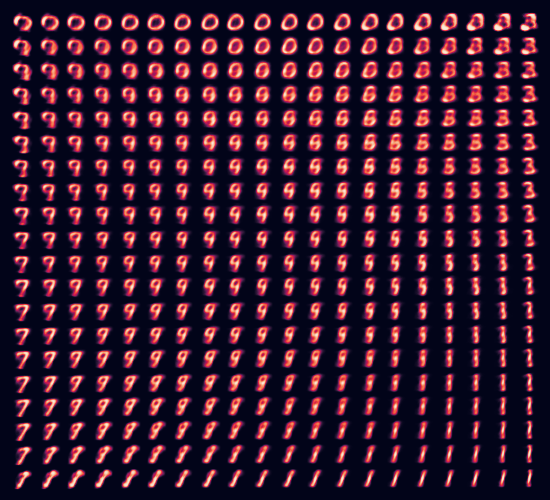

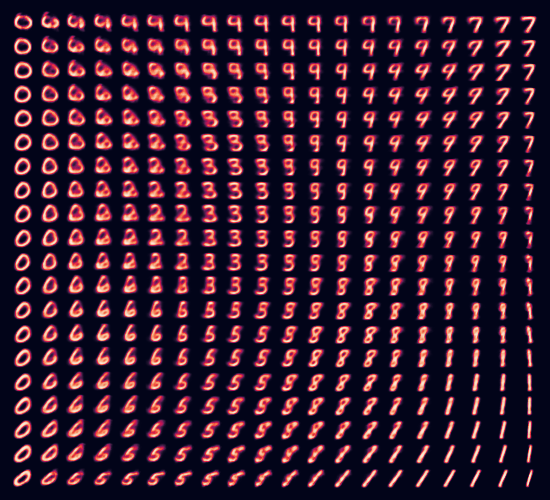

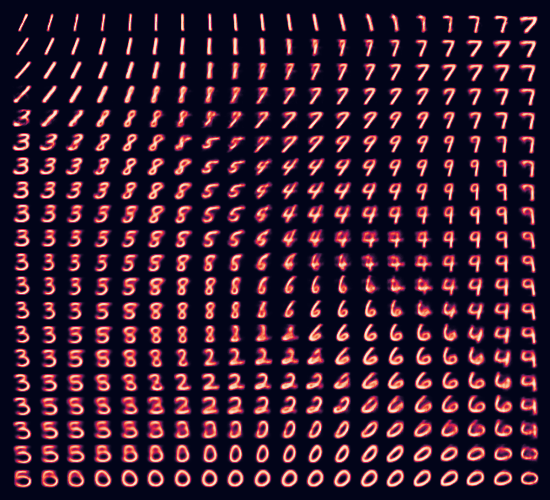

In [87]:
plot_model(trained_model_s, grid_size=20)
plot_model(trained_model_m, grid_size=20)
plot_model(trained_model_l, grid_size=20)

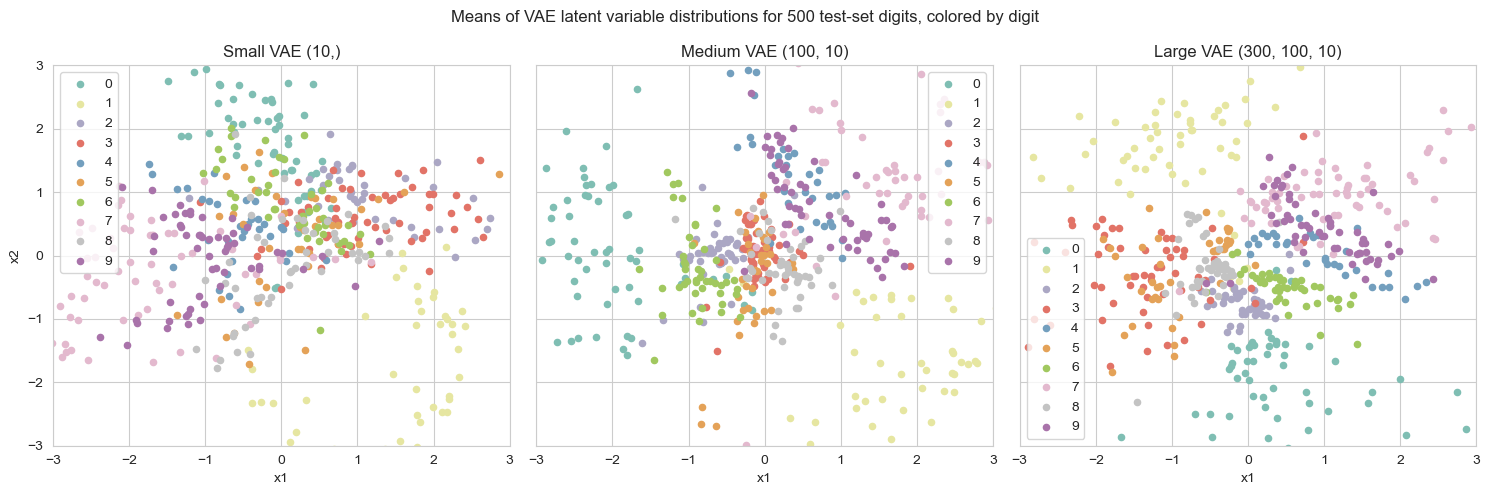

In [135]:
def plot_classes(
    model: VAE, batches: int = 1, title="", seed: int = 42, ax=None, limits: int = 3
):
    torch.random.manual_seed(seed)
    res = []
    if ax is None:
        _, ax = plt.subplots()
    with torch.no_grad():
        model.eval()
        for data, labels in islice(train_loader, batches):
            data = data.to(device)
            latents = model.encode(data).mean
            res.append(
                pl.DataFrame(
                    {
                        "x1": latents[:, 0].numpy(),
                        "x2": latents[:, 1].numpy(),
                        "Digit": labels.numpy(),
                    }
                )
            )
    for (dig, grp), col in zip(
        pl.concat(res).sort("Digit").group_by("Digit", maintain_order=True),
        plt.colormaps["Set3"].colors,
    ):
        grp.to_pandas().plot.scatter(
            x="x1", y="x2", label=dig[0], color=tuple(np.array(col) * 0.9), ax=ax
        )
    ax.set_xlim((-limits, limits))
    ax.set_ylim((-limits, limits))
    ax.set_title(title)


n_batches = 10
_, axs = plt.subplots(ncols=3, tight_layout=True, figsize=(15, 5), sharey=True)
plot_classes(trained_model_s, batches=n_batches, title="Small VAE (10,)", ax=axs[0])
plot_classes(
    trained_model_m, batches=n_batches, title="Medium VAE (100, 10)", ax=axs[1]
)
plot_classes(
    trained_model_l, batches=n_batches, title="Large VAE (300, 100, 10)", ax=axs[2]
)
plt.suptitle(
    "Means of VAE latent variable distributions for 500 test-set digits, colored by digit"
)
plt.show()

In [133]:
trained_model_multivar = train_loop(20, transform_dims=[300, 60, 10], multivariate=True)

Training [300, 60, 10]:   0%|          | 0/20 [00:00<?, ?epoch/s]

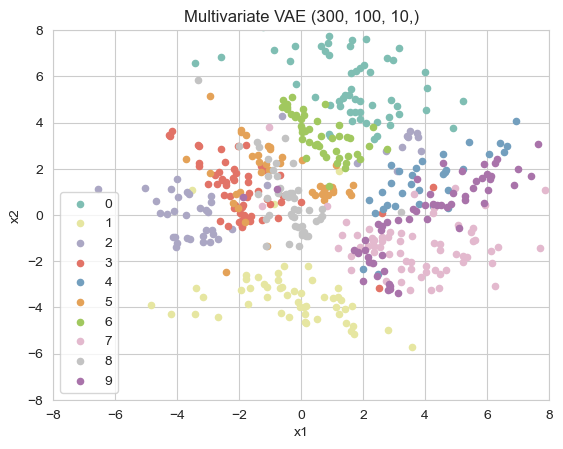

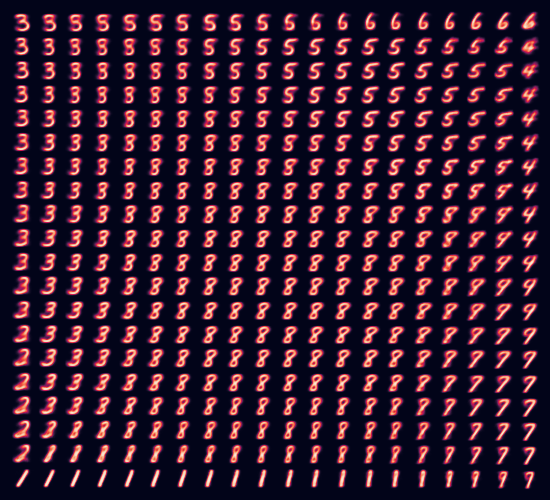

In [139]:
plot_classes(
    trained_model_multivar,
    batches=n_batches,
    title="Multivariate VAE (300, 100, 10,)",
    limits=8,
)
plot_model(trained_model_multivar, grid_size=20)